# Tilapia Regression Model with SARIMA
By Miguel Andre R. Pajarillo

## Load the Dataset

In [2]:
import pandas as pd

In [3]:
Tilapia_UN = pd.read_csv('./data/papaya_UN_papaya_UN.csv.csv')

In [4]:
Tilapia_DA = pd.read_csv('./data/papaya_DA_papaya_DA.csv.csv')

In [5]:
Tilapia_UN

,cm_id,cm_name,um_id,um_name,mp_month,mp_year,mp_price
0,408,Papaya - Retail,5,KG,5,2020,40.7000
1,408,Papaya - Retail,5,KG,5,2020,50.0000
2,408,Papaya - Retail,5,KG,5,2020,40.0000
3,408,Papaya - Retail,5,KG,5,2020,66.6700
4,408,Papaya - Retail,5,KG,5,2020,50.0000
...,...,...,...,...,...,...,...
672,408,Papaya - Retail,5,KG,2,2021,63.3333
673,408,Papaya - Retail,5,KG,3,2021,48.4700
674,408,Papaya - Retail,5,KG,4,2021,53.2200
675,408,Papaya - Retail,5,KG,5,2021,52.0400


In [6]:
Tilapia_DA.head()

,cm_id,cm_name,um_id,um_name,mp_month,mp_year,mp_price
0,NaN,Papaya - Retail,NaN,KG,1,2022,51.41
1,NaN,Papaya - Retail,NaN,KG,2,2022,50.08
2,NaN,Papaya - Retail,NaN,KG,3,2022,51.43
3,NaN,Papaya - Retail,NaN,KG,4,2022,51.45
4,NaN,Papaya - Retail,NaN,KG,5,2022,53.39


## Extract Necessary Columns (Date and Price)

### UN World Food Programme

In [7]:
Tilapia_UN['date'] = pd.to_datetime(
    Tilapia_UN.rename(columns={'mp_year': 'year', 'mp_month': 'month'})[['year', 'month']].assign(day=15)
)

In [8]:
Tilapia_UN = Tilapia_UN.drop(columns=['cm_id', 'cm_name', 'um_id', 'um_name', 'mp_month', 'mp_year'])

In [9]:
Tilapia_UN.head()

,mp_price,date
0,40.70,2020-05-15
1,50.00,2020-05-15
2,40.00,2020-05-15
3,66.67,2020-05-15
4,50.00,2020-05-15


### DA Bantay Presyo

In [10]:
Tilapia_DA['date'] = pd.to_datetime(
    Tilapia_DA.rename(columns={'mp_year': 'year', 'mp_month': 'month'})[['year', 'month']].assign(day=15)
)

In [11]:
Tilapia_DA = Tilapia_DA.drop(columns=['cm_id', 'cm_name', 'um_id', 'um_name', 'mp_month', 'mp_year'])

In [12]:
Tilapia_DA.head()

,mp_price,date
0,51.41,2022-01-15
1,50.08,2022-02-15
2,51.43,2022-03-15
3,51.45,2022-04-15
4,53.39,2022-05-15


In [13]:
import matplotlib.pyplot as plt

In [14]:
Tilapia = pd.concat([Tilapia_DA, Tilapia_UN])

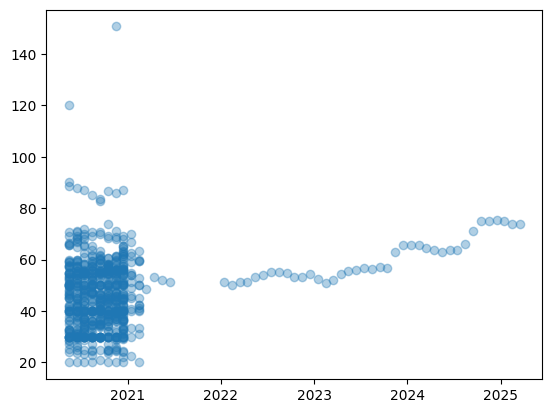

<Figure size 5000x600 with 0 Axes>

In [18]:
plt.scatter(Tilapia['date'], Tilapia['mp_price'], alpha=0.35)
plt.figure(figsize=(50, 6))
plt.show()

In [19]:
from datetime import datetime

In [20]:
# Set Date as the Inex
Tilapia = Tilapia.set_index('date')

In [21]:
# Aggregate samples to mean
Tilapia = Tilapia.resample('MS').mean()

In [22]:
Tilapia['mp_price'] = Tilapia['mp_price'].interpolate(method='linear')

In [23]:
print("🕓 Index Range:")
print(f"Start: {Tilapia.index.min()}")
print(f"End:   {Tilapia.index.max()}")
print(f"Index type: {type(Tilapia.index)}\n")

🕓 Index Range:
Start: 2020-05-01 00:00:00
End:   2025-03-01 00:00:00
Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>



In [26]:
start_date = datetime(2020,1,1)
end_date = datetime(2026,1,1)
lim_tilapia = Tilapia[start_date:end_date]

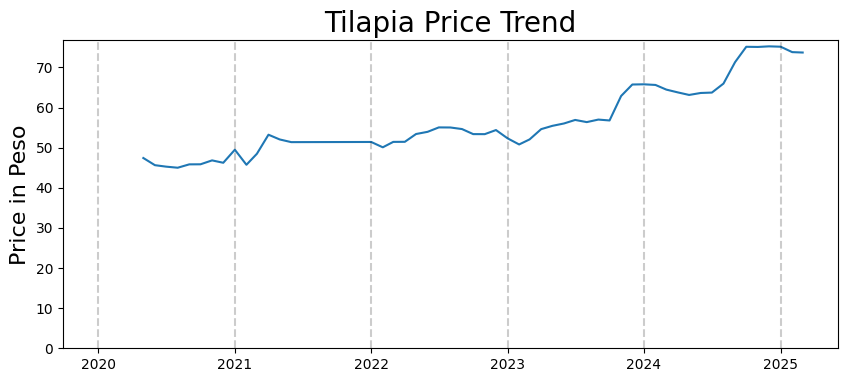

In [27]:
plt.figure(figsize=(10,4))
plt.plot(lim_tilapia)
plt.title('Tilapia Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
plt.ylim(bottom=0)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

## Remove the trend

In [28]:
first_diff = lim_tilapia.diff()[1:]

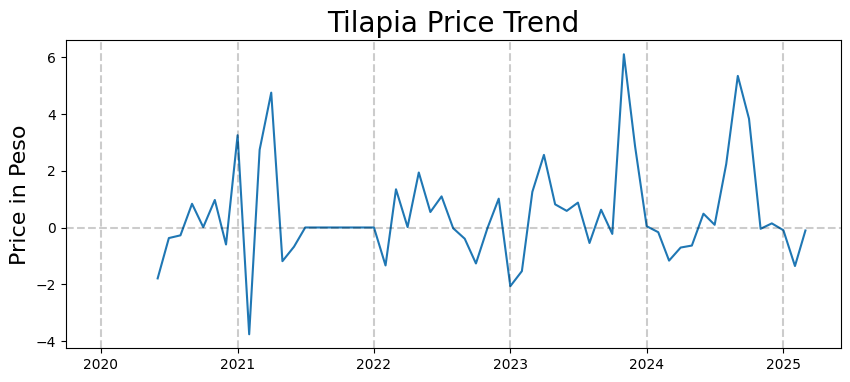

In [29]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('Tilapia Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(0, color='k', linestyle='--', alpha=0.2)

## ACF

In [30]:
from statsmodels.tsa.stattools import acf, pacf

<BarContainer object of 18 artists>

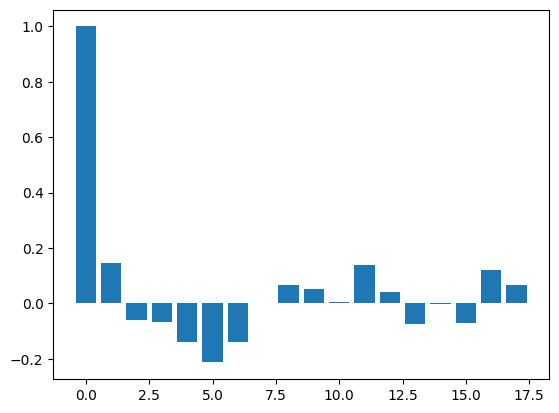

In [33]:
acf_vals = acf(first_diff)
num_lags = 18
plt.bar(range(num_lags), acf_vals[:num_lags])

### Based on ACF, we should start with a seasonal MA process

## PACF

<BarContainer object of 18 artists>

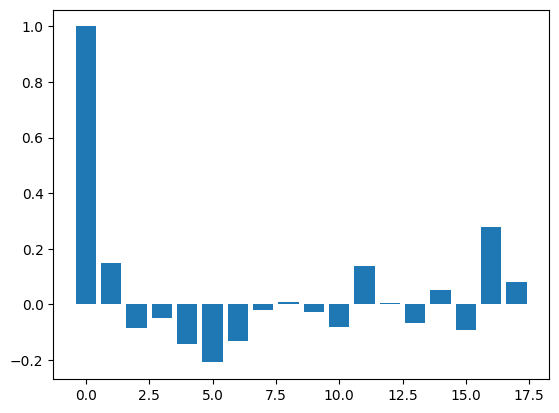

In [34]:
pacf_vals = pacf(first_diff)
num_lags = 18
plt.bar(range(num_lags), pacf_vals[:num_lags])

### Based on PACF, we should start with a seasonal AR process

## Get training and testing sets

In [35]:
from datetime import timedelta

In [36]:
train_end = datetime(2024,9,1)
test_end = datetime(2025,3,1)

train_data = lim_tilapia[:train_end]
test_data = lim_tilapia[train_end + timedelta(days=1):test_end]

In [37]:
Tilapia.describe()

,mp_price
count,59.000000
mean,56.380901
std,8.733255
min,44.991620
25%,51.378571
50%,53.390000
75%,63.375000
max,75.240000


## Fit the SARIMA Model

In [38]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [39]:
my_order = (0,1,0)
my_seasonal_order = (1, 0, 1, 12)
# define model
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)

In [40]:
from time import time

In [41]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.09262D+00    |proj g|=  1.69776D-01

At iterate    5    f=  1.97489D+00    |proj g|=  7.83935D-03

At iterate   10    f=  1.96918D+00    |proj g|=  3.11849D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     15      1     0     0   1.535D-06   1.969D+00
  F =   1.9691772492364947     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Model Fitting Time: 0.12627696990966797


 This problem is unconstrained.


In [42]:
#summary of the model
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                             mp_price   No. Observations:                   53
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -104.366
Date:                              Tue, 20 May 2025   AIC                            214.733
Time:                                      11:40:39   BIC                            220.587
Sample:                                  05-01-2020   HQIC                           216.977
                                       - 09-01-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.3595      0.917      0.392      0.695      -1.438       2.157
ma.S.L12      -0.14

In [43]:
print(type(test_data))
print(test_data.columns)
print(test_data.head())

<class 'pandas.core.frame.DataFrame'>
Index(['mp_price'], dtype='object')
            mp_price
date                
2024-10-01     75.13
2024-11-01     75.09
2024-12-01     75.24
2025-01-01     75.15
2025-02-01     73.80


In [44]:
# Assuming test_data is a DataFrame with a single column named "mp_price"
test_series = test_data['mp_price']

In [45]:
#get the predictions and residuals
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_series - predictions

In [46]:
predictions

date
2024-10-01    71.213465
2024-11-01    72.530620
2024-12-01    73.179273
2025-01-01    73.128349
2025-02-01    73.037944
2025-03-01    72.834450
Freq: MS, Name: predicted_mean, dtype: float64

In [47]:
residuals

date
2024-10-01    3.916535
2024-11-01    2.559380
2024-12-01    2.060727
2025-01-01    2.021651
2025-02-01    0.762056
2025-03-01    0.865550
Freq: MS, dtype: float64

Text(0, 0.5, 'Error')

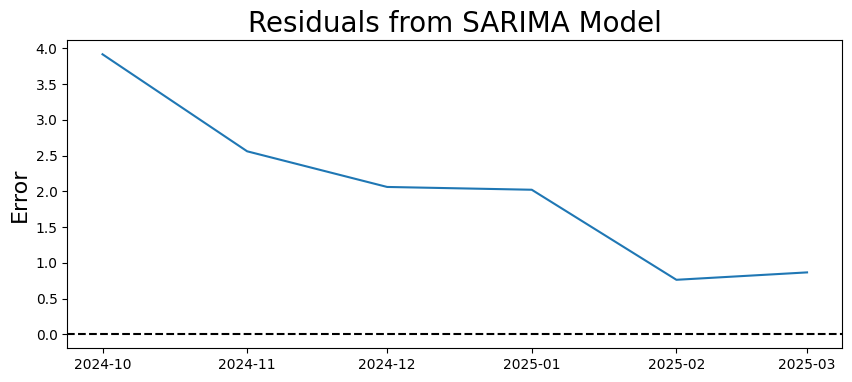

In [48]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

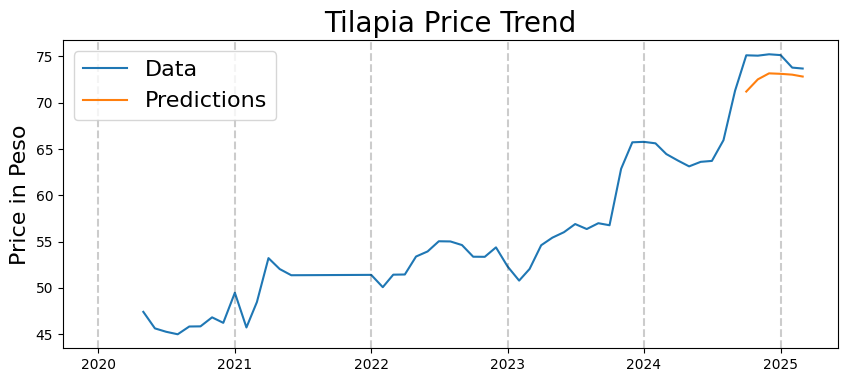

In [49]:
plt.figure(figsize=(10,4))

plt.plot(lim_tilapia)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Tilapia Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

## Using the Rolling Forecast Origin

In [50]:
rolling_predictions = test_series.copy()
for train_end in test_series.index:
    train_data = lim_tilapia[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

 This problem is unconstrained.
/tmp/ipykernel_173962/2554385675.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.09262D+00    |proj g|=  1.69776D-01

At iterate    5    f=  1.97489D+00    |proj g|=  7.83935D-03

At iterate   10    f=  1.96918D+00    |proj g|=  3.11849D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     15      1     0     0   1.535D-06   1.969D+00
  F =   1.9691772492364947     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

/tmp/ipykernel_173962/2554385675.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
 This problem is unconstrained.
/tmp/ipykernel_173962/2554385675.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
 This problem is unconstrained.



At iterate   10    f=  1.99757D+00    |proj g|=  1.24600D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     17      1     0     0   1.537D-05   1.998D+00
  F =   1.9975667211804875     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.04634D+00    |proj g|=  1.50002D-01

At iterate    5    f=  1.98940D+00    |proj g|=  5.73055D-04

At iterate   10    f=  1.98933D+00    |proj g|=  8.28825D-04

       

/tmp/ipykernel_173962/2554385675.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
 This problem is unconstrained.
/tmp/ipykernel_173962/2554385675.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.04129D+00    |proj g|=  1.66455D-01

At iterate    5    f=  1.97747D+00    |proj g|=  1.17117D-04

At iterate   10    f=  1.97747D+00    |proj g|=  4.15507D-04

At iterate   15    f=  1.97747D+00    |proj g|=  6.88938D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     17      1     0     0   6.889D-06   1.977D+00
  F =   1.9774703612388058     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/tmp/ipykernel_173962/2554385675.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred


In [51]:
rolling_residuals = test_series - rolling_predictions

Text(0, 0.5, 'Error')

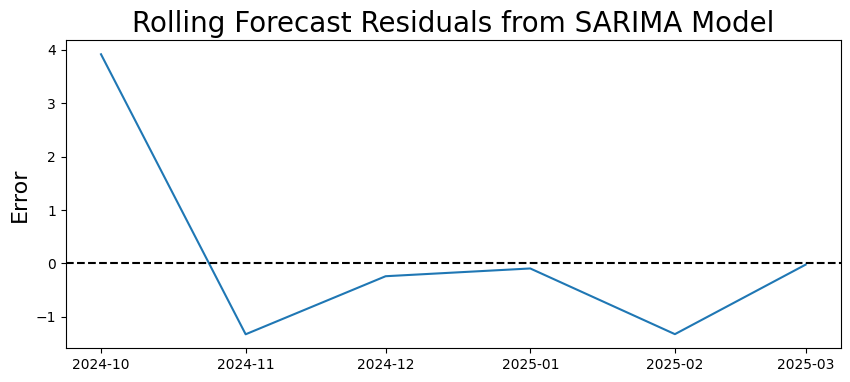

In [52]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

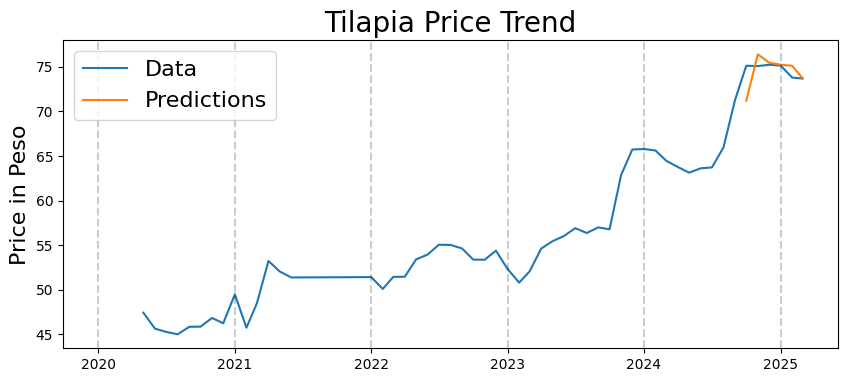

In [53]:
plt.figure(figsize=(10,4))

plt.plot(lim_tilapia)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Tilapia Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [54]:
import numpy as np

In [55]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_series)),4))

Mean Absolute Percent Error: 0.0154


In [56]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 1.775915109774655


## Future Predictions (2025)